In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df

In [69]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv")
hoyle_data = (
    hoyle_data[hoyle_data["task"]=="intrusions"]
    .drop(columns=[c for c in hoyle_data.columns if c[1]=="_"])
    .rename(columns={"dataset":"corpus", "topic_idx":"topic",
                     "human_idx":"rater", "scores_raw":"intrusion",
                     "confidences_raw":"confidence"})
    ).drop(columns=["task"])

In [76]:
corpus_ids = (hoyle_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (hoyle_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (hoyle_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

# topic_ids = (hoyle_data.groupby(["corpus", "model", "topic"], as_index=False)
#     .agg({"intrusion":"count"})
#     .drop(columns="intrusion"))
# topic_ids["topic_id"] = topic_ids.index 

rater_ids = (hoyle_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(hoyle_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
# Topic ids are no longer 0 - 299
# data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = d4.rename(columns={"topic" : "topic_id"})
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [77]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Model

In [78]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

In [79]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_topic = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}

In [104]:
np.ones(6).reshape(1,-1)

array([[1., 1., 1., 1., 1., 1.]])

In [108]:
# Topic only model

glm_topic["model"] = pm.Model()
with glm_topic["model"]:
    # Hyperparameter priors
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + za*sigma_a).mean(axis=1), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")
    
    glm_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 90 seconds.


In [109]:
glm_topic["summary_stat"] = create_summary_stat(glm_topic["trace"])

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) 

In [110]:
glm_topic["summary_stat"][glm_topic["summary_stat"]["param"]=="c_diff"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
308,c_diff,"0, 0",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN
309,c_diff,"0, 1",0.0934,0.0155,0.0640,0.1212,0.0003,0.0002,3557.1864,1382.3488,1.0018
310,c_diff,"0, 2",0.0329,0.0144,0.0045,0.0582,0.0002,0.0002,4002.1317,1417.7671,1.0000
311,c_diff,"0, 3",-0.0040,0.0140,-0.0311,0.0214,0.0002,0.0003,4916.8463,1566.7523,1.0004
312,c_diff,"0, 4",0.0402,0.0146,0.0140,0.0672,0.0002,0.0002,4779.2615,1453.8923,1.0001
313,c_diff,"0, 5",0.0281,0.0148,0.0007,0.0550,0.0002,0.0002,3962.6199,1499.1757,0.9996
314,c_diff,"1, 0",-0.0934,0.0155,-0.1212,-0.0640,0.0003,0.0002,3557.1864,1382.3488,1.0018
315,c_diff,"1, 1",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN
316,c_diff,"1, 2",-0.0605,0.0157,-0.0899,-0.0305,0.0002,0.0002,3984.6868,1348.2283,1.0000
317,c_diff,"1, 3",-0.0974,0.0153,-0.1251,-0.0677,0.0002,0.0002,4768.7591,1524.1807,0.9994


In [83]:
3glm_topic["summary_stat"][glm_topic["summary_stat"]["param"]!="za"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
300,mu,NaN,1.2199,0.0880,1.0536,1.3894,0.0041,0.0029,464.7849,701.5689,1.0072
301,sigma_a,NaN,1.3282,0.0694,1.1901,1.4499,0.0027,0.0019,640.6020,1081.7665,1.0038
302,c_mean,0,0.7437,0.0103,0.7244,0.7632,0.0002,0.0001,2829.3996,1444.4992,1.0003
303,c_mean,1,0.6507,0.0107,0.6304,0.6703,0.0002,0.0001,4231.4568,1824.3308,0.9999
304,c_mean,2,0.7108,0.0104,0.6913,0.7301,0.0002,0.0001,3263.7741,1210.2450,1.0025
305,c_mean,3,0.7484,0.0102,0.7288,0.7673,0.0002,0.0001,3653.9439,1817.4689,1.0001
306,c_mean,4,0.7039,0.0108,0.6825,0.7228,0.0002,0.0001,3390.7837,1398.3422,1.0012
307,c_mean,5,0.7155,0.0108,0.6952,0.7354,0.0002,0.0001,3970.4046,1662.3148,1.0021


In [86]:
cordel_ids

,corpus,model,cordel_id
0,nytimes,dvae,0
1,nytimes,etm,1
2,nytimes,mallet,2
3,wikitext,dvae,3
4,wikitext,etm,4
5,wikitext,mallet,5


[]

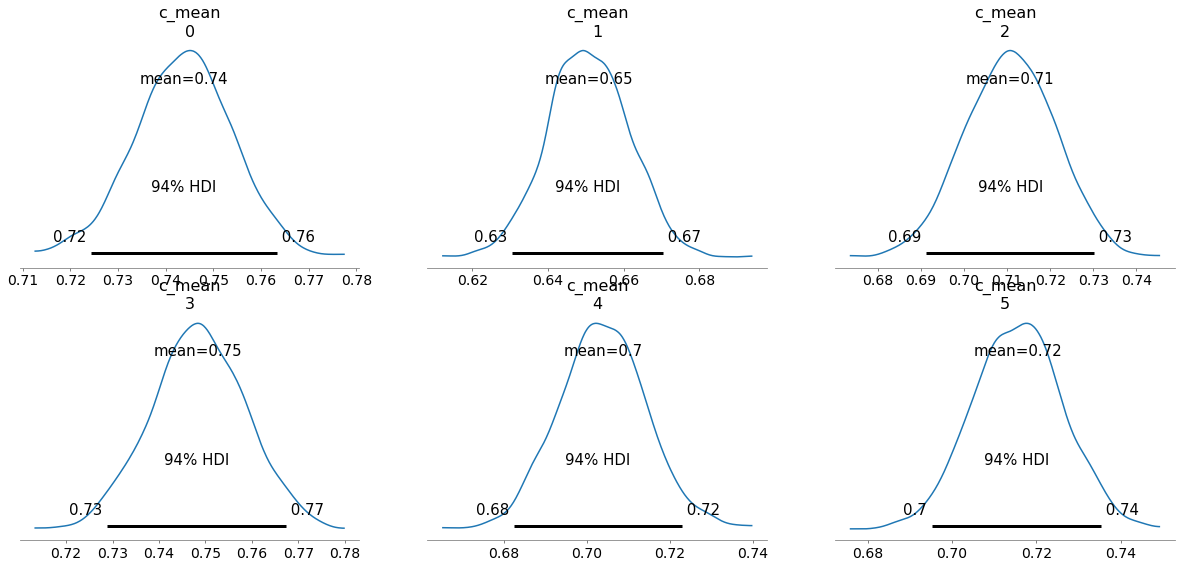

In [84]:
az.plot_posterior(glm_topic["trace"], var_names=["c_mean"])
plt.plot()

In [9]:
# Rater, Topic model

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
